## Application of extreme gradient boosting (Xgboost) to estimate suspended sediment concentration in rivers

In [1]:
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import multiprocessing
from sklearn.model_selection import GridSearchCV

## Define directories and filenames


In [2]:
main_dir = 'D:/Research/datasets/data_generated/LSTM_data/MS01/SR_data/EWRI_tutorial'
fname = 'dataLSTM_SR.txt'      # file containing data

## Read raw data

In [3]:
# Load textfile and exract relevant variable
filename = os.path.join(main_dir, fname)
data = pd.read_csv(filename, delimiter='\t')


In [4]:
data.columns

Index(['COMID', 'Date', 'Obs_SSC', 'Prcp', 'Tmin', 'Tmax', 'Srad', 'LAI',
       'redR', 'greenR', 'blueR', 'nirR', 'swir1R', 'swir2R', 'Sand', 'Silt',
       'Clay', 'slope_plane', 'length_channel', 'reservoir_Area(km2)',
       'reservoir_storage(km3)', 'D50(mm)', 'Barren(frac)', 'Developed(frac)',
       'Forest(frac)', 'Shrub(frac)', 'drainage_area'],
      dtype='object')

In [5]:
# Keep all the relevant data only
all_data = data[['COMID', 'Date', 'Obs_SSC', 'redR', 'greenR', 'blueR', 'nirR', 'swir1R', 'swir2R']]

In [6]:
all_data

,COMID,Date,Obs_SSC,redR,greenR,blueR,nirR,swir1R,swir2R
0,74003095,1983-1-1,26.0,NaN,NaN,NaN,NaN,NaN,NaN
1,74003095,1983-1-2,26.0,NaN,NaN,NaN,NaN,NaN,NaN
2,74003095,1983-1-3,22.0,NaN,NaN,NaN,NaN,NaN,NaN
3,74003095,1983-1-4,23.0,NaN,NaN,NaN,NaN,NaN,NaN
4,74003095,1983-1-5,23.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
549707,74053380,2017-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
549708,74053380,2017-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
549709,74053380,2017-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
549710,74053380,2017-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Number of unique rivers and corresponding number of observations
COMIDs = all_data['COMID'].unique()
nonNaN_counts = all_data.groupby('COMID')['redR'].count()

In [8]:
nonNaN_counts

COMID
74003095    561
74003144    672
74007350    236
74009490    559
74009572    324
74011566     30
74011582    337
74011588    233
74011806    574
74011963    369
74016346    291
74018337     43
74018444    185
74020458    429
74022428    382
74024444    647
74024722    144
74024788    442
74026679    447
74026796    557
74026878    288
74028978    575
74029066    578
74029091    325
74029102    510
74029298    319
74029311    558
74031353    644
74031469    563
74031470    571
74031483    630
74031785     16
74031859     88
74034090    316
74034193    312
74036896    379
74036998    540
74042209    318
74042270    489
74042437    379
74048225    199
74053373    568
74053380    244
Name: redR, dtype: int64

In [9]:
# identify the COMID with maximum number of remote sensing values
exp_comid = 74003095

In [10]:
# Extract the data for exp_comid
river_data = all_data[all_data['COMID']==exp_comid]

In [11]:
river_data

,COMID,Date,Obs_SSC,redR,greenR,blueR,nirR,swir1R,swir2R
0,74003095,1983-1-1,26.0,NaN,NaN,NaN,NaN,NaN,NaN
1,74003095,1983-1-2,26.0,NaN,NaN,NaN,NaN,NaN,NaN
2,74003095,1983-1-3,22.0,NaN,NaN,NaN,NaN,NaN,NaN
3,74003095,1983-1-4,23.0,NaN,NaN,NaN,NaN,NaN,NaN
4,74003095,1983-1-5,23.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
12779,74003095,2017-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12780,74003095,2017-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12781,74003095,2017-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12782,74003095,2017-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


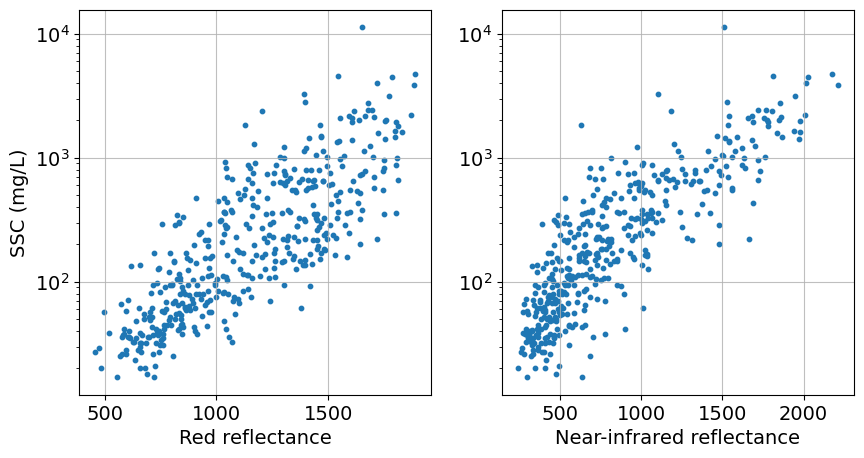

In [12]:
# Plot data
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.scatter(river_data['redR'], river_data['Obs_SSC'], s=10)
plt.yscale('log')
plt.xlabel('Red reflectance')
plt.ylabel('SSC (mg/L)')
plt.grid(alpha=0.8)

plt.subplot(1,2,2)
plt.scatter(river_data['nirR'], river_data['Obs_SSC'], s=10)
plt.yscale('log')
plt.xlabel('Near-infrared reflectance')
plt.grid(alpha=0.8)

plt.savefig(os.path.join(main_dir, 'reflectance_vs_SSC.tiff'), dpi=300)

In [13]:
# Indentify the rows containing RS data
indices = river_data['redR'].notna().to_numpy().nonzero()[0]

# Extract relevant data
final_data = river_data.iloc[indices]

# Now remove the rows containing NaN in place of obsSSC data
indices = final_data['Obs_SSC'].notna().to_numpy().nonzero()[0]
final_data = final_data.iloc[indices]

In [14]:
final_data

,COMID,Date,Obs_SSC,redR,greenR,blueR,nirR,swir1R,swir2R
472,74003095,1984-4-17,248.0,1488.972839,1258.038169,858.523204,1065.409560,233.0,206.0
504,74003095,1984-5-19,2810.0,1395.816050,1116.465807,790.420552,1530.257037,215.0,161.0
529,74003095,1984-6-13,960.0,1749.302467,1375.765907,883.900057,1722.296975,140.0,98.0
545,74003095,1984-6-29,630.0,1255.515123,1058.010108,666.327749,978.849543,150.0,102.0
552,74003095,1984-7-6,475.0,1226.796379,1031.168601,686.010742,955.394007,216.0,161.0
...,...,...,...,...,...,...,...,...,...
10800,74003095,2012-7-27,1020.0,1702.676471,1363.000000,880.443247,1763.697947,201.0,142.0
10809,74003095,2012-8-5,109.0,1262.437500,1169.303571,702.500000,684.275000,130.0,92.0
10832,74003095,2012-8-28,37.5,581.285714,710.461538,494.200000,462.181818,188.0,153.0
10848,74003095,2012-9-13,35.6,605.913043,739.000000,488.161905,365.000000,192.0,143.0


In [15]:
# Define parameters
trn_frac = 0.70

In [16]:
# Get training and test data
n = final_data.shape[0]
trn_last = int(trn_frac*n)
train_inds = range(0, trn_last)
test_inds = range(trn_last,n)

train_data, test_data = final_data.iloc[train_inds], final_data.iloc[test_inds]
ytrain, xtrain  = train_data['Obs_SSC'].values, train_data[['redR', 'greenR', 'blueR', 'nirR', 'swir1R', 'swir2R']].values
ytest, xtest  = test_data['Obs_SSC'].values, test_data[['redR', 'greenR', 'blueR', 'nirR', 'swir1R', 'swir2R']].values

In [17]:
# function to compute NSE
def computeNSE(obs, pred):
    sse = np.sum((obs - pred)**2)
    sst = np.sum((obs - np.mean(obs))**2)
    nse = 1 - sse/sst
    return nse

def XgboostParamTuning(X,y):
    if __name__ == "__main__":
        print("Parallel Parameter optimization")
        xgb_model = xgb.XGBRegressor(n_jobs=10, tree_method="hist",
                                    objective = 'reg:quantileerror', quantile_alpha=0.5, verbosity=0)
        clf = GridSearchCV(
            xgb_model,
            {"max_depth": [2, 4, 6, 8, 10, 15, 20], "n_estimators": [50, 100, 200], 'booster': ['gbtree', 'gblinear'],
             'eta': [0.10, 0.30, 0.50, 0.80, 1.00], 'subsample': [0.5, 0.75, 1.00]},
            verbose = 1,
            n_jobs = 2,
            cv = 3
        )
        clf.fit(X, y)
    
    return clf

In [18]:
# Cross-validation to determine the optimal hyperparameters
clf = XgboostParamTuning(xtrain, ytrain)
param = clf.best_params_

Parallel Parameter optimization
Fitting 3 folds for each of 630 candidates, totalling 1890 fits


In [19]:
param

{'booster': 'gbtree',
 'eta': 0.5,
 'max_depth': 2,
 'n_estimators': 200,
 'subsample': 1.0}

In [20]:
# Train the model
xgb_model = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count(), tree_method="hist", 
                             objective = 'reg:quantileerror', quantile_alpha=0.5, booster = param['booster'], max_depth=param['max_depth'], 
                             n_estimators=param['n_estimators'], eta=param['eta'], subsample=param['subsample'])
xgb_model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.5, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=48, num_parallel_tree=None, ...)

In [21]:
# predict for the test samples
ytest_est = xgb_model.predict(xtest)

Text(0.5, 0.98, 'NSE = 0.77, R$^2$ = 0.78, RMSE = 195.44 mg/L')

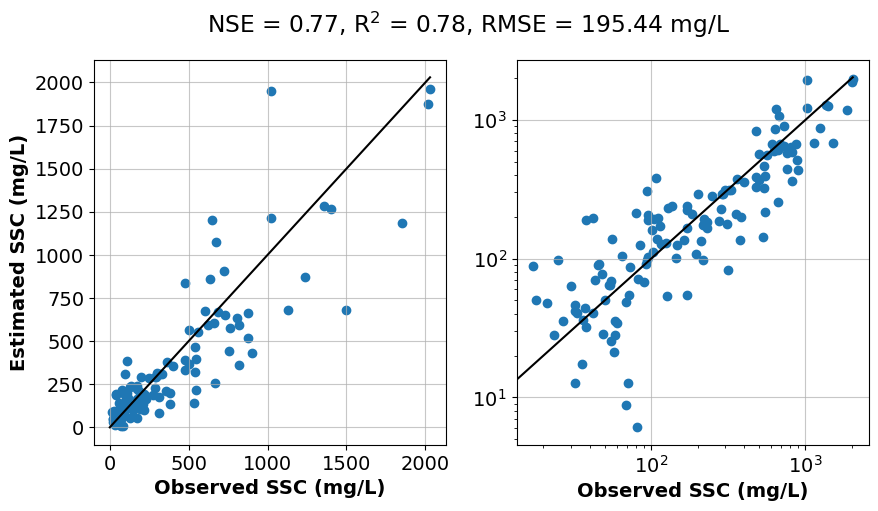

In [22]:
# Assess the model performance
nse = computeNSE(ytest, ytest_est)
r2 = np.corrcoef(ytest, ytest_est)[0,1]**2
rmse = np.mean((ytest - ytest_est)**2)**0.5

# Plot
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
mx = np.max((ytest, ytest_est))
plt.scatter(ytest, ytest_est)
plt.plot([0, mx], [0, mx], color='black')
plt.grid(alpha=0.7)
plt.xlabel('Observed SSC (mg/L)', fontweight = 'bold')
plt.ylabel('Estimated SSC (mg/L)', fontweight = 'bold')

plt.subplot(1,2,2)
mx = np.max((ytest, ytest_est))
plt.scatter(ytest, ytest_est)
plt.plot([0, mx], [0, mx], color='black')
plt.grid(alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed SSC (mg/L)', fontweight = 'bold')

plt.savefig(os.path.join(main_dir, 'observed_vs_predicted.tiff'), dpi=300)
plt.suptitle('NSE = {}, R$^2$ = {}, RMSE = {} mg/L'.format(round(nse, 2), round(r2, 2), round(rmse, 2)))